
Logistic Regression - Acurácia: 0.7403

Random Forest - Acurácia: 0.7576

KNN - Acurácia: 0.7186

Melhor modelo: Random Forest com acurácia de 0.7576
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.68      0.66        80

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



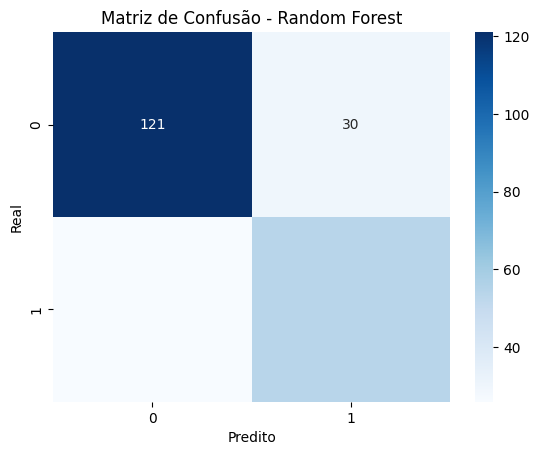

['../src/model.pkl']

In [2]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sys.path.append(os.path.abspath('../src'))
from data_preprocessing import load_and_clean_data, split_features_labels, normalize_features
from model import get_models, train_model, evaluate_model, save_model

# Etapa 1: Carregar e preparar dados
df = load_and_clean_data('../data/diabetes.csv')
X, y = split_features_labels(df)
X_scaled, scaler = normalize_features(X)

joblib.dump(scaler, '../src/scaler.pkl')

# Etapa 2: Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Etapa 3: Treinar e avaliar modelos
models = get_models()
best_model = None
best_score = 0
best_name = ''

for name, model in models.items():
    trained = train_model(model, X_train, y_train)
    acc, report, matrix = evaluate_model(trained, X_test, y_test)
    print(f'\n{name} - Acurácia: {acc:.4f}')

    if acc > best_score:
        best_model = trained
        best_score = acc
        best_name = name

print(f'\nMelhor modelo: {best_name} com acurácia de {best_score:.4f}')


# Exemplo com Random Forest
y_pred = best_model.predict(X_test)

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()


joblib.dump(best_model, '../src/model.pkl')